In [ ]:

!pip install --upgrade google-cloud


Found existing installation: db-dtypes 1.4.2
Uninstalling db-dtypes-1.4.2:
  Would remove:
    /Users/pranavigupta/data_to_decisions/prevention-data/.venv/lib/python3.13/site-packages/db_dtypes-1.4.2.dist-info/*
    /Users/pranavigupta/data_to_decisions/prevention-data/.venv/lib/python3.13/site-packages/db_dtypes/*
Proceed (Y/n)? ^C


In [ ]:
!pip install google-cloud-bigquery

!gcloud --version

Google Cloud SDK 516.0.0
bq 2.1.14
core 2025.03.24
gcloud-crc32c 1.0.0
gsutil 5.33
  Credentialed Accounts
ACTIVE  ACCOUNT
*       pg342@cornell.edu

To set the active account, run:
    $ gcloud config set account `ACCOUNT`



In [18]:
!gcloud auth list
!gcloud auth application-default login

  Credentialed Accounts
ACTIVE  ACCOUNT
        pg342@cornell.edu

To set the active account, run:
    $ gcloud config set account `ACCOUNT`

Your browser has been opened to visit:

    https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=764086051850-6qr4p6gpi6hn506pt8ejuq83di341hur.apps.googleusercontent.com&redirect_uri=http%3A%2F%2Flocalhost%3A8085%2F&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fsqlservice.login&state=E5ApfECoazz4gLStkcRYlFtjPsBdax&access_type=offline&code_challenge=iYClFPEl8l_glOF39hWOp2zIVAJdlOMfqMo1kY_df8g&code_challenge_method=S256


Credentials saved to file: [/Users/pranavigupta/.config/gcloud/application_default_credentials.json]

These credentials will be used by any library that requests Application Default Credentials (ADC).

Quota project "data-project-455021" was added to ADC which can be used by Google client lib

mimic3_v1_4


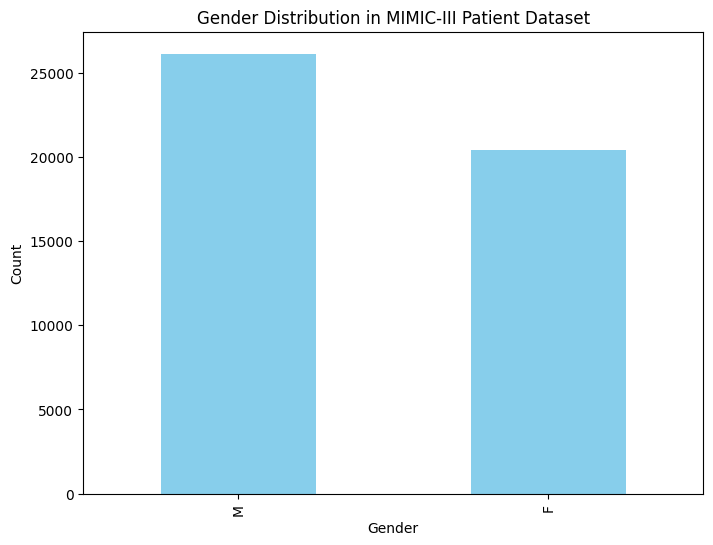

In [ ]:
from google.cloud import bigquery
from google.oauth2 import service_account
import pandas as pd
import matplotlib.pyplot as plt
import db_dtypes as db_dtypes

# Construct a BigQuery client object.
project_name = "replace-this-with-your-project-name"  # Replace with your project name

client = bigquery.Client(project=project_name)

# List datasets in the specified project
datasets = list(client.list_datasets())

# Print the dataset names
for dataset in datasets:
    print(dataset.dataset_id)

# TODO(developer): Set table_id to the ID of the destination table.
# table_id = "your-project.your_dataset.your_table_name"
sql = f'SELECT * FROM `{project_name}.mimic3_v1_4.PATIENTS`'
query_job = client.query(sql)

# df = query_job.to_dataframe()
rows = query_job.result()
patients_df = pd.DataFrame([dict(row) for row in rows])

plt.figure(figsize=(8, 6))
patients_df['GENDER'].value_counts().plot(kind='bar', color='skyblue')

plt.title('Gender Distribution in MIMIC-III Patient Dataset')
plt.xlabel('Gender')
plt.ylabel('Count')

plt.show()

In [ ]:

patients_df = patients_df.dropna(how='all')
admissions_sql = "SELECT * FROM `{project_name}.mimic3_v1_4.PATIENTS`"
admissions_query_job = client.query(admissions_sql)
admissions_rows = admissions_query_job.result()
admissions_df = pd.DataFrame([dict(row) for row in admissions_rows])
admissions_df = admissions_df.dropna(how='all')

In [44]:
!pip install bitarray
from bitarray import bitarray
import hashlib
import random
import math
random.seed(0)

class BloomFilter(object):
    def __init__(self, size, hash_count):
        """
        size: size of bit array
        hash_count: number of hash functions to use
        """
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.hash_param = []
        i=0
        while i<hash_count:
            a=random.randint(1,9999)
            b=random.randint(1,9999)
            p = self.generate_large_prime(30)
            self.hash_param.append((a,b,p))
            i+=1
            
    def generate_large_prime(self, bit_size):

        random_number = random.getrandbits(bit_size)
        
        while not self.is_prime(random_number):
            random_number = random.getrandbits(bit_size)
        return random_number

    def is_prime(self, number):
        if number % 2 == 0:
            return False


        for i in range(3, int(math.sqrt(number)) + 1, 2):
            if number % i == 0:
                return False

        return True
    def calculate_hash(self,item,hash_params):
        item_val = (hash_params[0]*item + hash_params[1])%hash_params[2]
        #print (item_val,hash_params[2])
        return item_val
    
    
    def add(self, item):
        """
        Add an item to the filter
        """
        for p in self.hash_param:
            self.bit_array[self.calculate_hash(item, p)% self.size] = 1
        
    def lookup(self, item):
        """
        Check for existence of an item in filter
        """

        for p in self.hash_param:
            if self.bit_array[self.calculate_hash(item, p)% self.size] == 0:
                return False
        
        return True

In [ ]:
# SQL query to join the admissions table with the diagnoses table
sql = """
SELECT
    a.SUBJECT_ID,
    a.HADM_ID,
    d.ICD9_CODE
FROM
    `{project_name}.mimic3_v1_4.PATIENTS` as a
JOIN
    `{project_name}.mimic3_v1_4.PATIENTS` as d
ON
    a.subject_id = d.subject_id AND a.hadm_id = d.hadm_id
"""
query_job = client.query(sql)
rows = query_job.result()

diagnoses_df = pd.DataFrame([dict(row) for row in rows])

diagnoses_df['DIAGNOSIS_FLAG'] = diagnoses_df['ICD9_CODE'].notnull()

# Left join because want to keep all admissions to the hospital, and add false to flag if no diagnosis was given
ground_truth_df = pd.merge(admissions_df, diagnoses_df[['SUBJECT_ID', 'HADM_ID', 'DIAGNOSIS_FLAG']], on=['SUBJECT_ID', 'HADM_ID'], how='left')

ground_truth_df = ground_truth_df[['SUBJECT_ID', 'HADM_ID', 'DIAGNOSIS', 'DIAGNOSIS_FLAG', 'HOSPITAL_EXPIRE_FLAG']]

ground_truth_df['DIAGNOSIS_FLAG'].fillna(False, inplace=True)
print("Ground Truth DataFrame:", len(ground_truth_df))
print(ground_truth_df.head(5))

Ground Truth DataFrame: 651047
   SUBJECT_ID  HADM_ID              DIAGNOSIS  DIAGNOSIS_FLAG  \
0        3369   126808                   None           False   
1       74869   123152   ? SEROTONIN SYNDROME            True   
2       74869   123152   ? SEROTONIN SYNDROME            True   
3       74869   123152   ? SEROTONIN SYNDROME            True   
4       74869   123152   ? SEROTONIN SYNDROME            True   

   HOSPITAL_EXPIRE_FLAG  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1  


/var/folders/lj/5mq9mzlx1t58q2x7hr_p8l5c0000gn/T/ipykernel_35220/3315752551.py:26: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  ground_truth_df['DIAGNOSIS_FLAG'].fillna(False, inplace=True)


In [ ]:
# Initialize the Bloom Filter with size and number of hash functions
bloom_filter = BloomFilter(size=100000, hash_count=5)

for subject_id in patients_df['SUBJECT_ID']:
    bloom_filter.add(subject_id)

filtered_admissions_df = admissions_df[admissions_df['SUBJECT_ID'].apply(
    lambda x: bloom_filter.lookup(x))]

result_df = pd.merge(patients_df, filtered_admissions_df, on='SUBJECT_ID', how='inner')

print("Patients DataFrame length", len(patients_df))
print("Admissions DataFrame length", len(admissions_df))
print("Filtered DataFrame length", len(filtered_admissions_df))
print("Patient-Admissions DataFrame length", len(result_df))

In [45]:
# Initialize the Bloom Filter with size and number of hash functions
bloom_filter = BloomFilter(size=100000, hash_count=5)

for subject_id in patients_df['SUBJECT_ID']:
    bloom_filter.add(subject_id)

filtered_admissions_df = admissions_df[admissions_df['SUBJECT_ID'].apply(
    lambda x: bloom_filter.lookup(x))]

result_df = pd.merge(patients_df, filtered_admissions_df, on='SUBJECT_ID', how='inner')

print("Patients DataFrame length", len(patients_df))
print("Admissions DataFrame length", len(admissions_df))
print("Filtered DataFrame length", len(filtered_admissions_df))
print("Patient-Admissions DataFrame length", len(result_df))

Patients DataFrame length 7593
Admissions DataFrame length 58976
Filtered DataFrame length 11921
Patient-Admissions DataFrame length 11554


In [ ]:
diagnoses_sql = "SELECT * FROM `{project_name}.mimic3_v1_4.PATIENTS`"
diagnoses = client.query(diagnoses_sql)
diagnoses_rows = diagnoses.result()
diagnoses_icd_df = pd.DataFrame([dict(row) for row in diagnoses_rows])
diagnoses_icd_df = diagnoses_icd_df.dropna(how='all')

print("Diagnoses DataFrame length", len(diagnoses_icd_df))
print("Patient-Admissions DataFrame length", len(result_df))

filtered_admissions_df = diagnoses_icd_df[diagnoses_icd_df['SUBJECT_ID'].apply(
    lambda x: bloom_filter.lookup(x))]

print("Filtered Admissions DataFrame length", len(filtered_admissions_df))
result_df = pd.merge(patients_df, diagnoses_icd_df, on='SUBJECT_ID', how='inner')

print("Patient-Admissions-Diagnoses DataFrame length", len(result_df))

Diagnoses DataFrame length 651047
Patient-Admissions DataFrame length 11554
Filtered Admissions DataFrame length 156331
Patient-Admissions-Diagnoses DataFrame length 152279
